## Import the necessary libraries and packages

In [2]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [3]:
import pandas as pd
from preprocess.discretization import discretization, get_nodes_type, code_categories, get_nodes_sign
from bayesian.train_bn import structure_learning, parameter_learning
from block_learning.partial_bn_train import connect_partial_bn, hierarchical_train, direct_connect, direct_train, range_pairs
import seaborn as sns
import numpy as np
from copy import  copy
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from bayesian.sampling import generate_synthetics
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import draw_BN, draw_comparative_hist
import networkx as nx
from pomegranate import log_probability, BayesianNetwork
from external.libpgm.sampleaggregator import SampleAggregator
import operator

Load the necessary data.  
The data was collected from the social network VKontakte using an open API.  
The variables are the following: 
## Socio-demographic data 
`age`  
`sex`  
`city_id` - city code  
`has_high_education`  
`relation` - marital status  
`num_of_relatives` - number of relatives  
...

## Information about interests  
`top1_interes` 
`top2_interes` 
`top3_interes` 
...

## Finance information
`max_tr` - maximum size of transaction  
`mean_tr`  
`cash_usage` 
...

In [4]:
vk_data = pd.read_csv('../data/vk_data.csv')
vk_data.head(10)

,sex,age,city_id,has_high_education,relation,num_of_relatives,followers_count,status,mobile_phone,twitter,...,"car, cars, sale, tires","sale, clothes, size, price, sewing","ingredients, cooking, dishes, salt, spices","theater, performance, actors","photographer, photography, show, wedding, photographer",top1_interes,top2_interes,top3_interes,top4_interes,top5_interes
0,1,50.0,2,0,0,2,27,0,0,0,...,0.201622,3.397819e-02,0.003674,0.308135,0.010700,"theater, performance, actors","car, cars, sale, tires","participation, festival, exhibition","client, project, internet, business, company","home, renovation, decoration, installation"
1,2,36.0,2,0,0,2,6,0,0,0,...,0.060985,2.529792e-02,0.020964,0.011533,0.003497,"book, reading, language, word, literature","music, concerts, rock, tickets, festivals","school, education, question, topic","client, project, internet, business, company","war, history, army, politics"
2,1,65.0,2,0,0,2,25,0,0,0,...,0.000009,2.007164e-09,0.100547,0.001567,0.049170,"client, project, internet, business, company","skin, face, care, cosmitology","ingredients, cooking, dishes, salt, spices","treatment, doctors, tests, clinic, health","photographer, photography, show, wedding, phot..."
3,2,30.0,2,0,0,2,52,0,1,0,...,0.143803,5.324164e-03,0.027627,0.014820,0.019036,"war, history, army, politics","car, cars, sale, tires","film, series, cinema, genre","music, concerts, rock, tickets, festivals","football, match, russia, team, goalkeeper"
4,2,36.0,2,0,0,2,18,0,0,0,...,0.037360,4.527913e-02,0.087596,0.043889,0.072074,"home, renovation, decoration, installation","ingredients, cooking, dishes, salt, spices","game, team, competition, sport","massage, meditation, yoga","shop, price, gifts, internet"
5,2,22.0,2,1,0,10,167,0,0,0,...,0.025479,1.996316e-02,0.010990,0.033827,0.035163,"music, concerts, rock, tickets, festivals","client, project, internet, business, company","school, education, question, topic","participation, festival, exhibition","film, series, cinema, genre"
6,2,23.0,2,0,0,2,275,1,0,0,...,0.073340,1.916149e-02,0.007811,0.019288,0.023399,"film, series, cinema, genre","car, cars, sale, tires","game, team, competition, sport","participation, festival, exhibition","music, concerts, rock, tickets, festivals"
7,1,27.0,2,0,0,2,475,0,0,0,...,0.005444,5.542228e-02,0.099362,0.061058,0.041686,"film, series, cinema, genre","ingredients, cooking, dishes, salt, spices","participation, festival, exhibition","dress, fashion, color, style","book, reading, language, word, literature"
8,2,25.0,2,0,0,2,37,0,0,0,...,0.052164,1.516378e-02,0.001627,0.020647,0.021668,"music, concerts, rock, tickets, festivals","film, series, cinema, genre","game, team, competition, sport","beauty, hair, manicure, salon","vacation, sea, accommodation, cost"
9,2,35.0,2,0,0,2,41,0,0,0,...,0.056157,5.284686e-02,0.011395,0.032997,0.020119,"home, renovation, decoration, installation","war, history, army, politics","participation, festival, exhibition","film, series, cinema, genre","car, cars, sale, tires"


In [3]:
node_types = get_nodes_type(vk_data)
node_types

{'sex': 'disc',
 'age': 'cont',
 'city_id': 'disc',
 'has_high_education': 'disc',
 'relation': 'disc',
 'num_of_relatives': 'disc',
 'followers_count': 'disc',
 'status': 'disc',
 'mobile_phone': 'disc',
 'twitter': 'disc',
 'facebook': 'disc',
 'instagram': 'disc',
 'about': 'disc',
 'about_topic': 'disc',
 'activities': 'disc',
 'activities_topic': 'disc',
 'books': 'disc',
 'interests': 'disc',
 'interests_topic': 'disc',
 'movies': 'disc',
 'music': 'disc',
 'quotes': 'disc',
 'personal_alcohol': 'disc',
 'personal_life_main': 'disc',
 'personal_people_main': 'disc',
 'personal_political': 'disc',
 'HLength': 'cont',
 'max_tr': 'cont',
 'min_tr': 'cont',
 'mean_tr': 'cont',
 'median_tr': 'cont',
 '90_perc': 'cont',
 'sum_am': 'cont',
 'tr_per_month': 'cont',
 'cash_sum': 'cont',
 'cash_usage': 'disc',
 'top1': 'disc',
 'top1_mean': 'cont',
 'top2': 'disc',
 'top2_mean': 'cont',
 'top3': 'disc',
 'top3_mean': 'cont',
 'game_sum': 'cont',
 'is_gamer': 'disc',
 'parent_sum': 'cont',


In [4]:
nodes_sign = get_nodes_sign(vk_data)
nodes_sign

{'age': 'pos',
 'HLength': 'pos',
 'max_tr': 'pos',
 'min_tr': 'pos',
 'mean_tr': 'pos',
 'median_tr': 'pos',
 '90_perc': 'pos',
 'sum_am': 'pos',
 'tr_per_month': 'pos',
 'cash_sum': 'pos',
 'top1_mean': 'pos',
 'top2_mean': 'pos',
 'top3_mean': 'pos',
 'game_sum': 'pos',
 'parent_sum': 'pos',
 'driver_sum': 'pos',
 'pets_sum': 'pos',
 'dress, fashion, color, style': 'pos',
 'massage, meditation, yoga': 'pos',
 'game, team, competition, sport': 'pos',
 'color, flowers, interior, design': 'pos',
 'iphone, apple, technology, equipment, smartphone': 'pos',
 'client, project, internet, business, company': 'pos',
 'war, history, army, politics': 'pos',
 'beauty, hair, manicure, salon': 'pos',
 'handmade, materials, products': 'pos',
 'work, schedule, earnings, money': 'pos',
 'music, concerts, rock, tickets, festivals': 'pos',
 'treatment, doctors, tests, clinic, health': 'pos',
 'school, education, question, topic': 'pos',
 'skin, face, care, cosmitology': 'pos',
 'book, reading, language

In [5]:
data = vk_data[['age',	'sex',	'has_high_education',	'relation',	'num_of_relatives','about',	'activities',	'books',	'interests',	'movies','top1_interes','top2_interes','top3_interes','top4_interes', 'top5_interes','max_tr',	'mean_tr', 'is_parent',	'is_driver',	'has_pets',	'cash_usage']] 

In [6]:
data.shape

(30000, 21)

In [7]:
coded_data, coder = code_categories(data, 'label', ['top1_interes','top2_interes','top3_interes','top4_interes', 'top5_interes'])

In [8]:
discrete, est = discretization(coded_data , 'equal_frequency', bins= 5, columns=['age', 'max_tr', 'mean_tr'])

The main idea is to build a modular structure of Bayesian networks, where each network represents some level of a person’s personal description.   
An example of such a structure is shown in the picture.

![title](img/modules_scheme.png)

In [9]:
module1 = data[['age',	'sex',	'has_high_education',	'relation',	'num_of_relatives']]
module2 = data[['about',	'activities',	'books',	'interests',	'movies']]
module3 = data[['top1_interes','top2_interes','top3_interes','top4_interes', 'top5_interes']]
module4 = data[['max_tr',	'mean_tr', 'is_parent',	'is_driver',	'has_pets',	'cash_usage']]

In [10]:
module1_d = discrete[['age',	'sex',	'has_high_education',	'relation',	'num_of_relatives']]
module2_d = discrete[['about',	'activities',	'books',	'interests',	'movies']]
module3_d = discrete[['top1_interes','top2_interes','top3_interes','top4_interes', 'top5_interes']]
module4_d = discrete[['max_tr',	'mean_tr', 'is_parent',	'is_driver',	'has_pets',	'cash_usage']]

In [11]:
node_type1 = get_nodes_type(module1)
node_type1

{'age': 'cont',
 'sex': 'disc',
 'has_high_education': 'disc',
 'relation': 'disc',
 'num_of_relatives': 'disc'}

In [12]:
node_type2 = get_nodes_type(module2)
node_type2

{'about': 'disc',
 'activities': 'disc',
 'books': 'disc',
 'interests': 'disc',
 'movies': 'disc'}

In [13]:
node_type3 = get_nodes_type(module3)
node_type3

{'top1_interes': 'disc',
 'top2_interes': 'disc',
 'top3_interes': 'disc',
 'top4_interes': 'disc',
 'top5_interes': 'disc'}

In [14]:
node_type4 = get_nodes_type(module4)
node_type4

{'max_tr': 'cont',
 'mean_tr': 'cont',
 'is_parent': 'disc',
 'is_driver': 'disc',
 'has_pets': 'disc',
 'cash_usage': 'disc'}

In [18]:
start = time.time()
bn = structure_learning(discrete, 'HC', node_types, 'K2')
param = parameter_learning(data, node_types, bn)
end = time.time()
print(end - start)

  0%|          | 54/1000000 [01:41<524:30:43,  1.89s/it] 
118.4262113571167


In [19]:
save_structure(bn, 'full_net')
skel = read_structure('full_net')
save_params(param, 'full_net_param')
params = read_params('full_net_param')
full = HyBayesianNetwork(skel, params)

In [17]:
draw_BN(bn, node_types, 'Full_net')

In [15]:
start = time.time()
bn1 = structure_learning(module1_d, 'HC', node_type1, 'K2')

  0%|          | 7/1000000 [00:00<12:25:39, 22.35it/s]


In [24]:
bn1

{'V': ['age', 'sex', 'has_high_education', 'relation', 'num_of_relatives'],
 'E': [['sex', 'age'],
  ['has_high_education', 'age'],
  ['relation', 'has_high_education'],
  ['relation', 'age'],
  ['relation', 'sex'],
  ['num_of_relatives', 'relation'],
  ['num_of_relatives', 'has_high_education']]}

In [22]:
draw_BN(bn1, node_type1, 'module1')

In [16]:
param1 = parameter_learning(module1, node_type1, bn1)

In [17]:
save_structure(bn1, 'skel1')
skel1 = read_structure('skel1')
save_params(param1, 'params1')
params1 = read_params('params1')
hybn1 = HyBayesianNetwork(skel1, params1)

In [18]:
bn2 = structure_learning(module2_d, 'HC', node_type2, 'K2')

  0%|          | 4/1000000 [00:00<25:35:45, 10.85it/s]


In [30]:
bn2

{'V': ['about', 'activities', 'books', 'interests', 'movies'],
 'E': [['books', 'movies'],
  ['interests', 'activities'],
  ['movies', 'interests'],
  ['movies', 'about']]}

In [31]:
draw_BN(bn2, node_type2, 'module2')

In [19]:
param2 = parameter_learning(module2, node_type2, bn2)

In [20]:
save_structure(bn2, 'skel2')
skel2 = read_structure('skel2')
save_params(param2, 'params2')
params2 = read_params('params2')
hybn2 = HyBayesianNetwork(skel2, params2)

In [35]:
end = time.time()
print(end - start)

2.421198844909668


In [21]:
bn3 = structure_learning(module3_d, 'HC', node_type3, 'K2')
bn3

  0%|          | 5/1000000 [00:00<31:40:49,  8.77it/s]


{'V': ['top1_interes',
  'top2_interes',
  'top3_interes',
  'top4_interes',
  'top5_interes'],
 'E': [['top1_interes', 'top2_interes'],
  ['top1_interes', 'top3_interes'],
  ['top1_interes', 'top4_interes'],
  ['top1_interes', 'top5_interes'],
  ['top2_interes', 'top3_interes']]}

In [36]:
draw_BN(bn3, node_type3, 'module3')

In [22]:
param3 = parameter_learning(module3, node_type3, bn3)

In [23]:
save_structure(bn3, 'skel3')
skel3 = read_structure('skel3')
save_params(param3, 'params3')
params3 = read_params('params3')
hybn3 = HyBayesianNetwork(skel3, params3)

In [42]:
end = time.time()
print(end - start)

3.4464473724365234


In [24]:
bn4 = structure_learning(module4_d, 'HC', node_type4, 'K2')
bn4

  0%|          | 13/1000000 [00:00<10:21:47, 26.80it/s]


{'V': ['max_tr',
  'mean_tr',
  'is_parent',
  'is_driver',
  'has_pets',
  'cash_usage'],
 'E': [['mean_tr', 'max_tr'],
  ['is_parent', 'mean_tr'],
  ['is_parent', 'max_tr'],
  ['is_driver', 'mean_tr'],
  ['is_driver', 'is_parent'],
  ['has_pets', 'mean_tr'],
  ['has_pets', 'cash_usage'],
  ['has_pets', 'is_parent'],
  ['cash_usage', 'max_tr'],
  ['cash_usage', 'is_parent'],
  ['cash_usage', 'mean_tr'],
  ['cash_usage', 'is_driver']]}

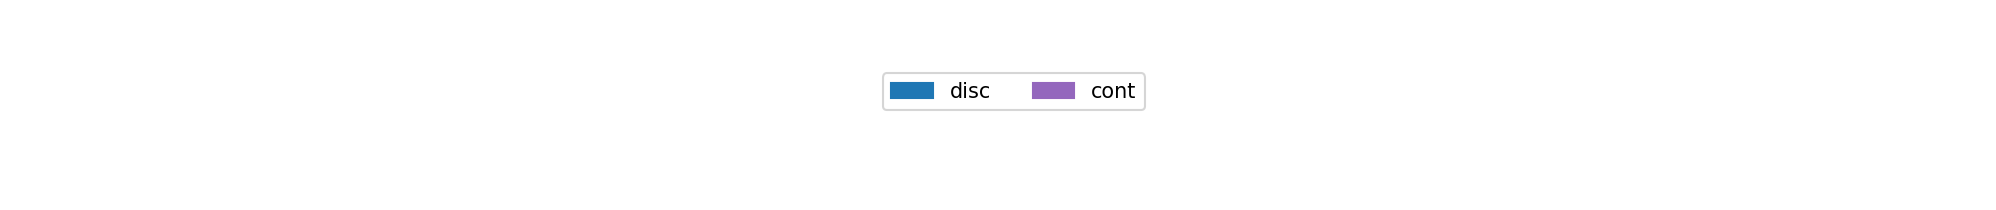

In [46]:
draw_BN(bn4, node_type4, 'module4')

In [25]:
param4 = parameter_learning(module4, node_type4, bn4)

In [26]:
save_structure(bn4, 'skel4')
skel4 = read_structure('skel4')
save_params(param4, 'params4')
params4 = read_params('params4')
hybn4 = HyBayesianNetwork(skel4, params4)

In [49]:
end = time.time()
print(end - start)

5.370755910873413


In [27]:
hybn_connect = direct_connect([bn1,bn2, bn3, bn4], discrete, node_types)

  0%|          | 33/1000000 [00:09<84:05:38,  3.30it/s]['0 1', '0 2', '0 3']



In [28]:
hybns = [bn1,bn2, bn3, bn4]

In [31]:
hybn_final = direct_train(hybns, coded_data, hybn_connect)

0 1
0 2
0 3


In [67]:
end = time.time()
print(end - start)

220.57396340370178


In [68]:
final_struct = dict()
final_struct['V'] = hybn_final.V
final_struct['E'] = hybn_final.E

In [69]:
final_struct['V'] 

['relation_status',
 'has_high_education',
 'number_of_relatives',
 'age',
 'sex',
 'L 0_1',
 'number_of_activities',
 'number_of_interests',
 'number_of_movies',
 'number_of_books',
 'len_of_about',
 'L 1_3',
 'L 0_2',
 'L 0_4',
 'cash_usage',
 'parent',
 'driver',
 'has_pets',
 'L 4_2',
 'mean_tr',
 'max_tr',
 'L 0_3',
 'nodes',
 'L 3_2',
 'top1',
 'top2',
 'top3',
 'top4',
 'degree_assortativity_coefficient',
 'eigenvector_centrality',
 'betweenness_centrality',
 'density']

In [70]:
final_struct['E']

[['top1', 'top3'],
 ['driver', 'max_tr'],
 ['number_of_movies', 'number_of_books'],
 ['number_of_activities', 'number_of_interests'],
 ['number_of_relatives', 'L 0_3'],
 ['eigenvector_centrality', 'betweenness_centrality'],
 ['has_pets', 'L 4_2'],
 ['cash_usage', 'mean_tr'],
 ['number_of_relatives', 'L 0_2'],
 ['nodes', 'L 3_2'],
 ['mean_tr', 'max_tr'],
 ['nodes', 'density'],
 ['L 0_1', 'number_of_activities'],
 ['parent', 'max_tr'],
 ['top3', 'top4'],
 ['L 0_2', 'top1'],
 ['top2', 'top3'],
 ['parent', 'driver'],
 ['L 4_2', 'top1'],
 ['sex', 'L 0_1'],
 ['sex', 'L 0_2'],
 ['number_of_relatives', 'L 0_4'],
 ['nodes', 'degree_assortativity_coefficient'],
 ['has_pets', 'mean_tr'],
 ['degree_assortativity_coefficient', 'betweenness_centrality'],
 ['cash_usage', 'driver'],
 ['top1', 'top2'],
 ['number_of_relatives', 'L 0_1'],
 ['has_high_education', 'number_of_relatives'],
 ['sex', 'L 0_4'],
 ['parent', 'has_pets'],
 ['parent', 'L 4_2'],
 ['top2', 'top4'],
 ['age', 'sex'],
 ['cash_usage', 'p

In [32]:
sample = generate_synthetics(hybn_final, nodes_sign)

In [33]:
sample

,num_of_relatives,relation,sex,has_high_education,L 0_1,books,movies,about,interests,activities,...,top3_interes,top5_interes,top4_interes,L 0_3,has_pets,cash_usage,is_driver,is_parent,mean_tr,max_tr
0,10,1,2,0,2,0,0,0,0,0,...,15,0,13,2,0,1,0,0,8460.253261,264342.559592
1,116,0,1,1,2,1,1,117,0,0,...,16,13,16,0,0,1,0,0,20014.273942,86088.403806
2,10,1,1,0,2,0,0,0,0,0,...,14,16,22,0,0,1,0,1,2400.701858,52445.257798
3,10,4,1,1,0,0,0,0,0,0,...,25,8,13,1,0,1,0,0,973.293207,251236.378272
4,10,4,1,0,0,13,0,0,0,0,...,14,9,7,1,0,1,0,1,12284.878462,319384.379049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,10,4,2,0,0,0,0,0,0,0,...,13,15,0,1,0,1,0,0,3744.816356,82432.211069
996,10,0,1,1,1,18,1,1,1,14,...,15,11,9,0,0,0,0,0,8842.612141,40145.780343
997,10,4,2,0,0,0,0,0,0,0,...,19,22,18,1,1,1,0,1,1148.524609,33768.210815
998,117,0,1,0,2,0,0,100,0,0,...,11,5,18,0,1,1,0,0,1065.107618,8779.735464
